In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM 
from keras.utils import plot_model, multi_gpu_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

/usr/local/anaconda3/envs/hackaubi/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set_style("whitegrid")
np.random.seed(0)

DATA_PATH = ''
EMBEDDING_PATH = './wiki.en.vec'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])


In [3]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_PATH, encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

414it [00:00, 4137.80it/s]

loading word embeddings...


2519428it [05:26, 7727.81it/s]

found 2519396 word vectors


In [4]:
import xlrd

#输入文件路径，返回list;list内包含n个字典形式数据集
def read_xlsx(path):
    book = xlrd.open_workbook(path)
    first_sheet = book.sheet_by_index(0)
    result = []
    index = 0
    #print(first_sheet.row_values(3))
    key = first_sheet.row_values(index)
    print('key = ',key)
    index += 1
    while(1):
        try:
            #print(type(first_sheet.row_values(index)))
            dic = dict(zip(key,first_sheet.row_values(index)))
            result.append(dic)
            index += 1
        except Exception:
            break
    print('done')
    # print('result = ',result)
    return result, key

xlsx_file = './reviews_language_helpful_funny_comment_stripped.xlsx'
data_dict, label_name = read_xlsx(xlsx_file)

('key = ', [u'content', u'language', u'vote_up_count', u'vote_funny_count', u'comment_count'])
done


In [5]:
def zt(data):
	weight_vote_up = 1.0
	weight_vote_funny = 0.5
	weight_comment = 2.0
	max = 0.0
	temp = 0.0
	new_data = list()
	for votes in data:
		if(votes['vote_up_count']==0.0 and votes['vote_funny_count']==0.0 and votes['comment_count']==0.0):
			continue
		votes['weight_temp']=votes['vote_up_count']*weight_vote_up + votes['vote_funny_count']*weight_vote_funny + votes[ 'comment_count']*weight_comment
		new_data.append(votes)
		if(max < votes['weight_temp']):
			max = votes['weight_temp']

	zt_list = list()
	zt_gay_list = list()
	for i in range(int(max*2)+1):
		zt_list.append(0)
	for votes in new_data:
		zt_list[int(votes['weight_temp']*2)]=zt_list[int(votes['weight_temp']*2)] + 1
	lenge = len(new_data)
	for i in range(int(max*2)+1):
		zt_gay_list.append((temp+zt_list[i]/2)/lenge)
		temp = temp + zt_list[i]

	for votes in new_data:
		votes['score'] = zt_gay_list[int(votes['weight_temp']*2)]
		if(votes['score']<0.2):
			votes['class'] = [1,0,0,0]
		elif(votes['score']<0.5):
			votes['class'] = [0,1,0,0]
		elif(votes['score']<0.8):
			votes['class'] = [0,0,1,0]
		else:
			votes['class'] = [0,0,0,1]
		del votes['vote_up_count']
		del votes['vote_funny_count']
		del votes['comment_count']
		del votes['weight_temp']

	return new_data

In [6]:
# languages
languages = set()
for data in data_dict:
    languages.add(data['language'])
print(languages)
current_language = 'english'

set([u'portuguese', u'german', u'japanese', u'spanish', u'polish', u'swedish', u'turkish', u'romanian', u'czech', u'dutch', u'schinese', u'danish', u'bulgarian', u'hungarian', u'ukrainian', u'brazilian', u'french', u'norwegian', u'koreana', u'russian', u'thai', u'tchinese', u'finnish', u'greek', u'english', u'italian'])


In [7]:
# read
current_language_data = [data for data in data_dict if data['language'] == current_language ]

In [8]:
current_language_data[:3]

[{u'comment_count': 1.0,
  u'content': u'Wayyyyy better than GTA:IV',
  u'language': u'english',
  u'vote_funny_count': 0.0,
  u'vote_up_count': 0.0},
 {u'comment_count': 1.0,
  u'content': u'IMO, the best GTA. If not just for the voice acting.',
  u'language': u'english',
  u'vote_funny_count': 0.0,
  u'vote_up_count': 0.0},
 {u'comment_count': 0.0,
  u'content': u'Just awesome. Awesomeness by awesome.',
  u'language': u'english',
  u'vote_funny_count': 0.0,
  u'vote_up_count': 1.0}]

In [9]:
current_language_data = zt(current_language_data)

In [10]:
raw_docs_train = [ data['content'] for data in current_language_data]
labels = [ data['class'] for data in current_language_data]

In [11]:
print(labels[10:15])

[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0]]


In [12]:
#visualize word distribution
# train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
# sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
# plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
# plt.title('comment length'); plt.legend()
# plt.show()
max_seq_len = 0
for data in current_language_data:
    max_seq_len = max(len(data['content']), max_seq_len)
print(max_seq_len)

8000


In [13]:
print("pre-processing train data...")
processed_docs = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs.append(" ".join(filtered))

  7%|▋         | 1656/24691 [00:00<00:01, 16529.43it/s]

pre-processing train data...


100%|██████████| 24691/24691 [00:00<00:00, 26454.11it/s]


In [14]:
processed_docs[:4]

[u'Wayyyyy better GTA IV',
 u'IMO best GTA If voice acting',
 u'Just awesome Awesomeness awesome',
 u'Gimme ticket']

In [15]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs)  #leaky
word_seq = tokenizer.texts_to_sequences(processed_docs)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
('dictionary size: ', 35988)


In [16]:
word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)

In [17]:
y_all = np.array(labels)

In [18]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return len([x.name for x in local_device_protos if x.device_type == 'GPU'])
num_gpus = get_available_gpus()
print("GPUS:{}".format(num_gpus))

GPUS:8


In [19]:
#training params
batch_size = 256 
num_epochs = 20 
num_gpus = num_gpus

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4
learning_rate = 0.001

#output parameters
num_classes = 4

#data split
split_persentage = 0.8
split_index = int(len(word_seq) * split_persentage)
word_seq_train = word_seq[:split_index]
word_seq_test = word_seq[split_index:]
y_train = y_all[:split_index]
y_test = y_all[split_index:]

In [20]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 9533


In [21]:
print("sample words not found: ", np.random.choice(words_not_found, 20))

('sample words not found: ', array([u'32523205', u'138s', u'158', u'hxn8', u'tacofiction', u'mate2',
       u'saaaaaandy', u'reflexs', u'concluzie', u'krokodilopolis',
       u'ilovethisgame', u'\u0e01\u0e32\u0e23\u0e01\u0e25', u'bugishit',
       u'c6', u'anywhom', u'lightning2', u'77', u'\u0e19\u0e40\u0e1b',
       u'eargrading', u'7600k'], dtype='<U3577'))


In [22]:
# **BUG FIX**
# BUG FIXED: cannot save model while using multi GPU 

from keras.layers import Lambda, concatenate
from keras import Model
import tensorflow as tf


def multi_gpu_model(model, gpus):
    if isinstance(gpus, (list, tuple)):
        num_gpus = len(gpus)
        target_gpu_ids = gpus
    else:
        num_gpus = gpus
        target_gpu_ids = range(num_gpus)

    def get_slice(data, i, parts):
        shape = tf.shape(data)
        batch_size = shape[:1]
        input_shape = shape[1:]
        step = batch_size // parts
        if i == num_gpus - 1:
            size = batch_size - step * i
        else:
            size = step
        size = tf.concat([size, input_shape], axis=0)
        stride = tf.concat([step, input_shape * 0], axis=0)
        start = stride * i
        return tf.slice(data, start, size)

    all_outputs = []
    for i in range(len(model.outputs)):
        all_outputs.append([])

    # Place a copy of the model on each GPU,
    # each getting a slice of the inputs.
    for i, gpu_id in enumerate(target_gpu_ids):
        with tf.device('/gpu:%d' % gpu_id):
            with tf.name_scope('replica_%d' % gpu_id):
                inputs = []
                # Retrieve a slice of the input.
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_i = Lambda(get_slice,
                                     output_shape=input_shape,
                                     arguments={'i': i,
                                                'parts': num_gpus})(x)
                    inputs.append(slice_i)

                # Apply model on slice
                # (creating a model replica on the target device).
                outputs = model(inputs)
                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save the outputs for merging back together later.
                for o in range(len(outputs)):
                    all_outputs[o].append(outputs[o])

    # Merge outputs on CPU.
    with tf.device('/cpu:0'):
        merged = []
        for name, outputs in zip(model.output_names, all_outputs):
            merged.append(concatenate(outputs,
                                      axis=0, name=name))
        return Model(model.inputs, merged)


In [34]:
#Model architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
try:
    model = ulti_gpu_model(model, gpus=num_gpus)
    print("Training using multiple GPUs..")
except:
    print("Training using single GPU or CPU..")
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Training using single GPU or CPU..
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8000, 300)         10796400  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8000, 64)          134464    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4000, 64)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4000, 64)          28736     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)     

In [24]:
# save model

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
filepath = current_language + '.' + 'weights.ep{epoch:03d}.loss{loss:.3f}.val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]

In [25]:
#model training
hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=1)

Train on 17776 samples, validate on 1976 samples
Epoch 1/20
17776/17776 [==============================] - 20s 1ms/step - loss: 0.5608 - acc: 0.7493 - val_loss: 0.5422 - val_acc: 0.7500
Epoch 2/20
17776/17776 [==============================] - 6s 365us/step - loss: 0.5444 - acc: 0.7499 - val_loss: 0.5275 - val_acc: 0.7500
Epoch 3/20
17776/17776 [==============================] - 6s 357us/step - loss: 0.5337 - acc: 0.7506 - val_loss: 0.5172 - val_acc: 0.7504
Epoch 4/20
17776/17776 [==============================] - 6s 351us/step - loss: 0.5300 - acc: 0.7508 - val_loss: 0.5156 - val_acc: 0.7503
Epoch 5/20
17776/17776 [==============================] - 6s 362us/step - loss: 0.5274 - acc: 0.7515 - val_loss: 0.5134 - val_acc: 0.7505
Epoch 6/20
17776/17776 [==============================] - 6s 355us/step - loss: 0.5239 - acc: 0.7522 - val_loss: 0.5200 - val_acc: 0.7514
Epoch 7/20
17776/17776 [==============================] - 6s 353us/step - loss: 0.5228 - acc: 0.7536 - val_loss: 0.5161 - va

In [26]:
hist.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

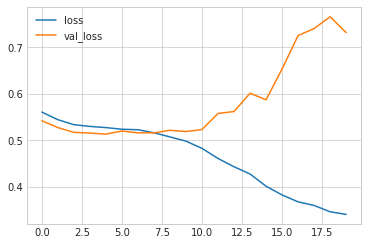

In [28]:
train_history = hist
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)